# Setup 

This first cell set the working directory as the project directory:

In [36]:
import os

if os.getcwd().endswith('notebooks'):
    os.chdir('..')
print(os.getcwd())

/home/cmcouto-silva/Projects/github/pytorch-workflow-mastery


## Libraries

In [37]:
import torch
from torch import nn
from torch.optim import Adam, SGD
import torchmetrics
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import ResNet18_Weights, resnet18

from tqdm import tqdm
from loguru import logger

import numpy as np
import matplotlib.pyplot as plt

## Device

In [38]:
# [Optional] Enable TF32 for better performance on modern NVIDIA GPUs
torch.set_float32_matmul_precision('high')

In [39]:
# Set available device (CPU or GPU - cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Config Parameters

In [40]:
# Random seed
seed = 42

# Training parameters
num_epochs = 3
batch_size = 128  # Larger batches for faster training
learning_rate = 0.001

# Model parameters
num_classes = 10  # CIFAR10 has 10 classes
model_path = 'weights/cifar10_model.pt'  # Path to save/load model weights

# DataLoader settings
train_num_workers = 4  # Number of parallel processes for data loading
test_num_workers = 4   # Increase these if you have more CPU cores

In [41]:
## -- Set seeds -- ##

# CPU seed
torch.manual_seed(seed)  # Controls random number generation for PyTorch CPU operations

# NumPy seed (for data loading/processing)
np.random.seed(seed)     # Controls random number generation for NumPy operations

# If GPU is available
if torch.cuda.is_available():
    # GPU seed
    torch.cuda.manual_seed(seed)  # Controls random number generation for PyTorch GPU operations
    # Force CUDA to use deterministic algorithms
    torch.backends.cudnn.deterministic = False  # Makes GPU operations deterministic (might be slower)
    
# Set `deterministic = False` because we'll prioritize performance over reproducibility =S

# Dataset

For real-life applications, the image folder is usually structured as:

```text
data/
├── train/
│   ├── airplane/        # This folder name becomes class 0
│   │   ├── img1.jpg
│   │   ├── img2.jpg
│   ├── automobile/      # This folder name becomes class 1
│   │   ├── img1.jpg
│   │   ├── img2.jpg
│   └── ...
├── val/
│   ├── airplane/
│   ├── automobile/
│   └── ...
└── test/
    ├── airplane/
    ├── automobile/
    └── ...
```

So we can use `torchvision.datasets.ImageFolder` to load the dataset, passing it to `DataLoader` as shown here.

In [42]:
# Data Transformers

train_transformer = transforms.Compose([   # Transformations like resizing and normalizaing alongside data augmentation
    transforms.ToTensor(),
    # Data Augmentation,
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

val_transformer = transforms.Compose([     # Usually Resizing and normalizaton without data augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transformer = transforms.Compose([    # Usually same as validation transformation 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [43]:
## -- Download & load data -- ##

# Datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transformer)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=val_transformer)

# DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=train_num_workers,
    pin_memory = True
)

val_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=train_num_workers,
    pin_memory = True
)

# Test set -> not available in this example, but real-life applications require test data - mainly when tuning hyperparameters!!

Files already downloaded and verified
Files already downloaded and verified


# Model

In [44]:
device

device(type='cuda')

In [45]:
# Load model
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify the final layer for CIFAR-10 (10 classes)
model.fc = nn.Linear(model.fc.in_features, 10)

# Set it to target device
model = model.to(device)

# [Optional] Compile model to make it faster (torch>=2.0)
model = torch.compile(model)

# Set up loss function
criterion = nn.CrossEntropyLoss()

# Set up optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Schedule for learning rate
# search torch scheduler

In [46]:
# Metrics
train_loss = torchmetrics.MeanMetric().to(device)
val_loss = torchmetrics.MeanMetric().to(device)
train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

## Train

In [48]:
logger.info("Starting training...")

for epoch in range(num_epochs):

    ## -- Train step -- ##
    
    model.train()
    train_loss.reset()
    train_accuracy.reset()

    train_progress = tqdm(train_loader, desc=f'• Epoch {epoch + 1}/{num_epochs} [Train]', leave=False)

    for images, labels in train_progress:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # Update metrics
        train_loss.update(loss)
        train_accuracy.update(outputs, labels)

        train_progress.set_postfix({
            'loss': f'{train_loss.compute():.3f}',
            'acc': f'{train_accuracy.compute():.1%}'
        })

    ## -- Validation step -- ##

    model.eval()
    val_loss.reset()
    val_accuracy.reset()

    with torch.inference_mode(): # another option: torch.no_grad()
        val_progress = tqdm(
            val_loader, desc=f'• Epoch {epoch + 1}/{num_epochs} [Valid]', leave=False
        )

        for images, labels in val_progress:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Update metrics
            val_loss.update(loss)
            val_accuracy.update(outputs, labels)
            
            val_progress.set_postfix({
                'loss': f'{val_loss.compute():.3f}',
                'acc': f'{val_accuracy.compute():.1%}'
            })

    # Print epoch summary
    logger.debug(
        f"Epoch {epoch+1}/{num_epochs}: "
        f"Train Loss: {train_loss.compute():.3f} | "
        f"Train Acc: {train_accuracy.compute():.1%} | "
        f"Val Loss: {val_loss.compute():.3f} | "
        f"Val Acc: {val_accuracy.compute():.1%}"
    )

logger.success('Model trained!')

2024-12-04 13:58:29.274 | INFO     | __main__:<module>:1 - Starting training...
2024-12-04 13:58:39.512 | DEBUG    | __main__:<module>:62 - Epoch 1/3: Train Loss: 0.351 | Train Acc: 88.1% | Val Loss: 0.240 | Val Acc: 92.2%
2024-12-04 13:58:49.856 | DEBUG    | __main__:<module>:62 - Epoch 2/3: Train Loss: 0.272 | Train Acc: 90.7% | Val Loss: 0.213 | Val Acc: 92.6%
2024-12-04 13:59:00.206 | DEBUG    | __main__:<module>:62 - Epoch 3/3: Train Loss: 0.217 | Train Acc: 92.6% | Val Loss: 0.135 | Val Acc: 95.5%
2024-12-04 13:59:00.206 | SUCCESS  | __main__:<module>:70 - Model trained!


In [50]:
# Save fine-tuned model and training state
torch.save({
   'model_state_dict': model.state_dict(),          # Model weights
   'optimizer_state_dict': optimizer.state_dict(),  # Optimizer state
   'epoch': num_epochs,                             # Number of trained epochs
}, model_path)

logger.info(f"Model saved to {model_path}")

2024-12-04 13:59:57.082 | INFO     | __main__:<module>:8 - Model saved to weights/cifar10_model.pt


## Inference

In [51]:
# Load checkpoint
checkpoint = torch.load(model_path, weights_only=True)

# Initialize model architecture
model = resnet18()
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Compile model as training
model = model.to(device) 
model = torch.compile(model)

# Load model weights
model.load_state_dict(checkpoint['model_state_dict']);

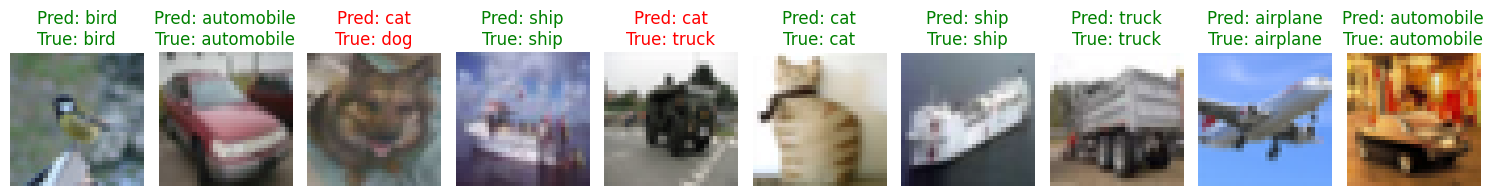

In [52]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples to visualize
n_samples = 10

# Get random indices
val_indices = np.random.choice(len(val_dataset), size=n_samples, replace=False)

# Set up the plot
plt.figure(figsize=(15, 3))

# Get class names from CIFAR10
classes = val_dataset.classes

model.eval()
with torch.inference_mode():
    for idx, sample_idx in enumerate(val_indices):

        # Get the image and label
        image, true_label = val_dataset[sample_idx]
        
        # Add batch dimension and move to device
        image = image.unsqueeze(0).to(device)
        
        # Get prediction
        output = model(image)
        predicted_label = output.argmax(1).item()
        
        # Convert image for display
        img = image.cpu().squeeze()
        img = img.permute(1, 2, 0)  # Change from CxHxW to HxWxC
        
        # Denormalize the image
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        img = img * std + mean
        
        # Plot
        plt.subplot(1, n_samples, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        color = 'green' if predicted_label == true_label else 'red'
        plt.title(
            f'Pred: {classes[predicted_label]}\n'
            f'True: {classes[true_label]}',
            color=color
        )

plt.tight_layout()
plt.show()